# 2.1.8 Challenge - Preparing a Dataset for Modeling
## Avocado Prices
#### Sam Fradkin

In [1]:
%%HTML
<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton"
value="Show Code"></form>

## 1. Background

This dataset is from Kaggle, which was originally taken from http://www.hassavocadoboard.com/retail/volume-and-price-data. 

After conducting some research into the Avocado market, it appears that the most significant contributing factors to the price of avocados is farming conditions. Some examples include the 2016 heatwave experienced in California and Mexico, the two locations from where most of the United States' avocados come, and the California fires in December 2017. This events caused the yields to be drastically smaller than usual, and we can see the effect of this shortage in the pricing spikes seen in 2016 and 2017.

In [2]:
# Import all libraries that will be needed
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import calendar
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
%matplotlib inline

from IPython.display import Image
from IPython.core.display import HTML 

import warnings
warnings.filterwarnings('ignore')

In [33]:
# Pull in the dataset and get a preview of it.
data = pd.read_csv('avocado.csv')
data.head()

,Unnamed: 0,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


In [34]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18249 entries, 0 to 18248
Data columns (total 14 columns):
Unnamed: 0      18249 non-null int64
Date            18249 non-null object
AveragePrice    18249 non-null float64
Total Volume    18249 non-null float64
4046            18249 non-null float64
4225            18249 non-null float64
4770            18249 non-null float64
Total Bags      18249 non-null float64
Small Bags      18249 non-null float64
Large Bags      18249 non-null float64
XLarge Bags     18249 non-null float64
type            18249 non-null object
year            18249 non-null int64
region          18249 non-null object
dtypes: float64(9), int64(2), object(3)
memory usage: 1.9+ MB


In [35]:
data.describe()

,Unnamed: 0,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,year
count,18249.000000,18249.000000,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,18249.000000,18249.000000
mean,24.232232,1.405978,8.506440e+05,2.930084e+05,2.951546e+05,2.283974e+04,2.396392e+05,1.821947e+05,5.433809e+04,3106.426507,2016.147899
std,15.481045,0.402677,3.453545e+06,1.264989e+06,1.204120e+06,1.074641e+05,9.862424e+05,7.461785e+05,2.439660e+05,17692.894652,0.939938
min,0.000000,0.440000,8.456000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,2015.000000
25%,10.000000,1.100000,1.083858e+04,8.540700e+02,3.008780e+03,0.000000e+00,5.088640e+03,2.849420e+03,1.274700e+02,0.000000,2015.000000
50%,24.000000,1.370000,1.073768e+05,8.645300e+03,2.906102e+04,1.849900e+02,3.974383e+04,2.636282e+04,2.647710e+03,0.000000,2016.000000
75%,38.000000,1.660000,4.329623e+05,1.110202e+05,1.502069e+05,6.243420e+03,1.107834e+05,8.333767e+04,2.202925e+04,132.500000,2017.000000
max,52.000000,3.250000,6.250565e+07,2.274362e+07,2.047057e+07,2.546439e+06,1.937313e+07,1.338459e+07,5.719097e+06,551693.650000,2018.000000


## 2. Chosing Variables

__Outcome Variable:__   Average Price<br><br>
__Other Variables:__<br>
_Categorical:_      Region, Type<br>
_Continuous:_       Date, Total Volume, Total Bags, 4225 (Haas-L)<br><br>
Let's see how our outcome variable, __Average Price__, is distributed.

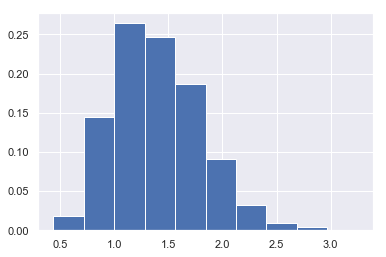

In [36]:
# sns.distplot was not showing total distribution values on the y axis so switched 
# to plt.hist with a weights attribute
weights = np.ones_like(np.array(data['AveragePrice']))/float(len(np.array(data['AveragePrice'])))
plt.hist(data['AveragePrice'], weights=weights)
plt.show()

It looks like we have some duplicate data in our dataset causing values to reach above the 100% mark so we will try this again after cleaning our data.

## 3. Data Cleaning 

After initially looking at the data, it seems that some data cleaning is required:<br><br>
__1)__ In order to utilize the Date field as a continuous variable, we need to convert it to DATETIME format <br>
__2)__ It appears that the Region column includes triple values - it has individual cities, regions, and TotalUS. I would like to deal specifically with the grouped regions.<br><br>
__3__ We should check out a heatmap of null values in the dataset to see if they need to be addressed.

In [37]:
# Remove the 'Unnamed: 0' column as it adds no value
data.drop('Unnamed: 0', axis=1, inplace=True)

In [38]:
data.head()

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


In [39]:
# Convert 'Date' column to date type
data['Date'] = pd.to_datetime(data['Date'])

In [40]:
# Convert the Type column into integers so the model can use it.
data['Organic'] = data['type'].replace(['conventional','organic'],[0,1])

In [41]:
# The dataset includes rows for individual markets as well as market regions.
# Therefore, all individual market rows should be removed so double values do not occur.
regions = ['California', 'Plains', 'GreatLakes', 'Southeast',
           'West', 'SouthCentral', 'Midsouth', 'Northeast']
rgdata = data.loc[data['region'].isin(regions)]

In [42]:
# Rename the columns for clarity
rgdata = rgdata.rename(columns={'AveragePrice': 'Avg Price', '4046': 'Haas-S', 
                            '4225': 'Haas-L', '4770': 'Haas-XL', 'type': 'Type', 
                            'year': 'Year', 'region': 'Region'})

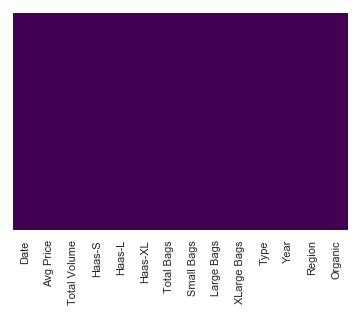

In [43]:
# Create a heatmap of null values to see how prevalent they are and how to address them
sns.heatmap(rgdata.isnull(),yticklabels=False,cbar=False,cmap='viridis')
plt.show()

It looks like there are no instances of null values in our dataset! It looks like were are ready to check out the distribution of the Average Price again.

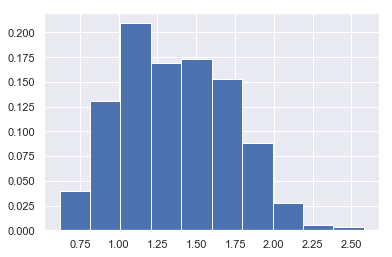

In [44]:
weights = np.ones_like(np.array(rgdata['Avg Price']))/float(len(np.array(rgdata['Avg Price'])))
plt.hist(rgdata['Avg Price'], weights=weights)
plt.show()

It looks like there is somewhat of a normal distribution of __Average Price__. Let us know see if there are any obvious correlations between the columns.

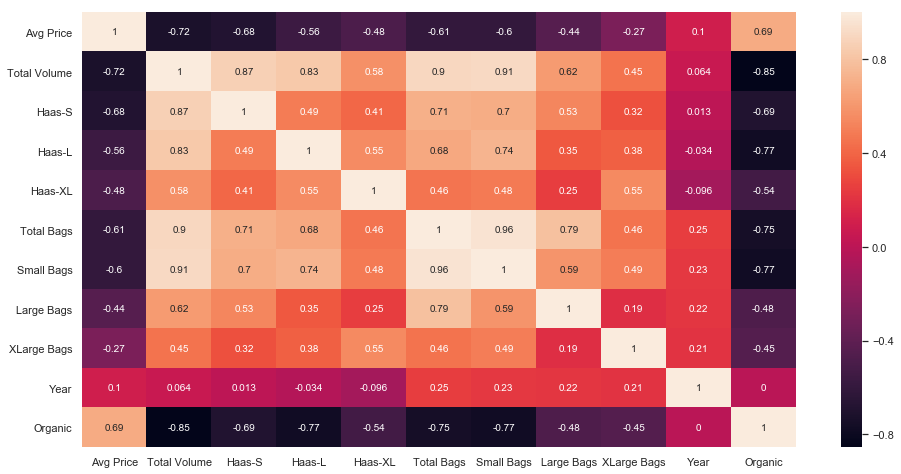

In [45]:
plt.figure(figsize=(16,8))
sns.heatmap(rgdata.corr(), annot=True)
plt.show()

## 4. Univariate and Bivariate Variable Exploration

One quick way to see possible relations between continuous variables and univariate plots is with a PairGrid.

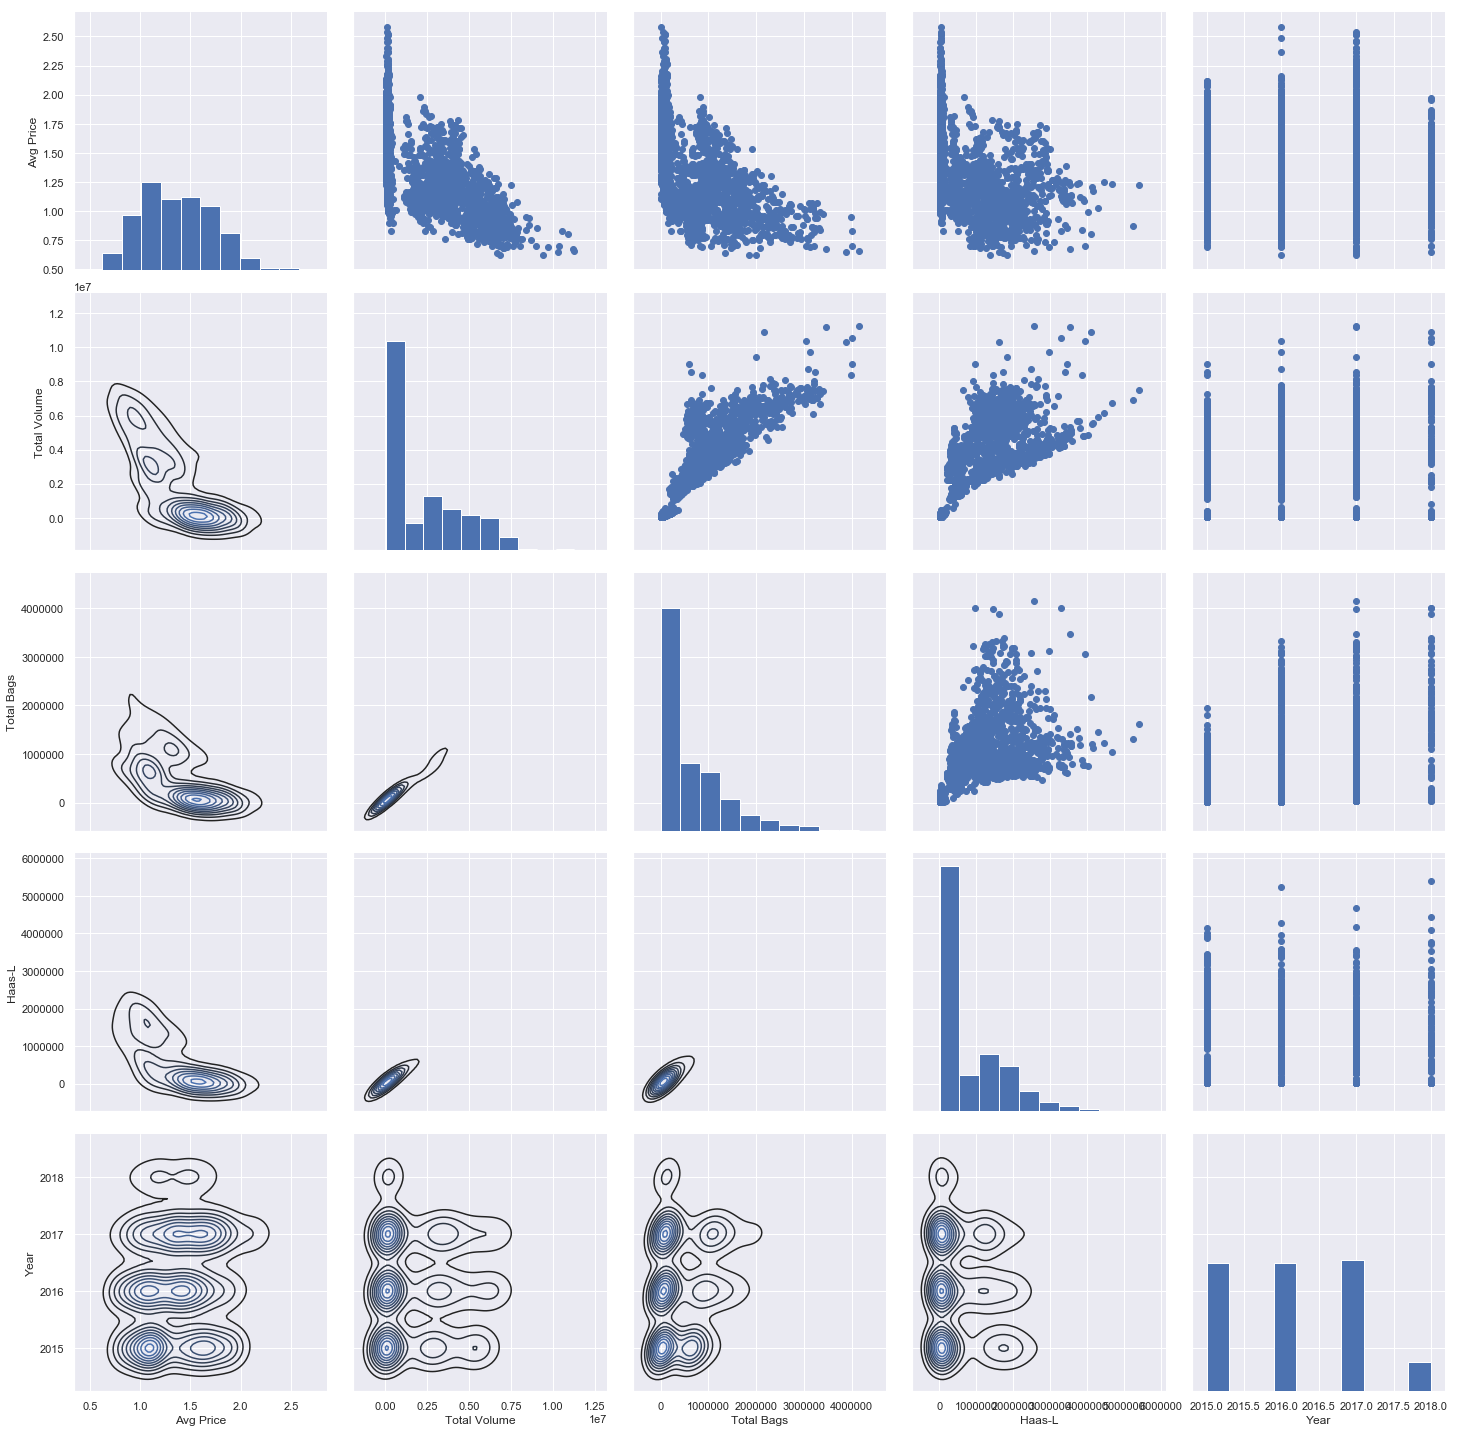

In [46]:
grid = sns.PairGrid(rgdata, vars=['Avg Price', 'Total Volume', 'Total Bags',
                                  'Haas-L', 'Year'], size=4)
grid = grid.map_upper(plt.scatter)
grid = grid.map_diag(plt.hist)
grid = grid.map_lower(sns.kdeplot)
plt.show()

Now let's check out the relationship between Date and Average Price

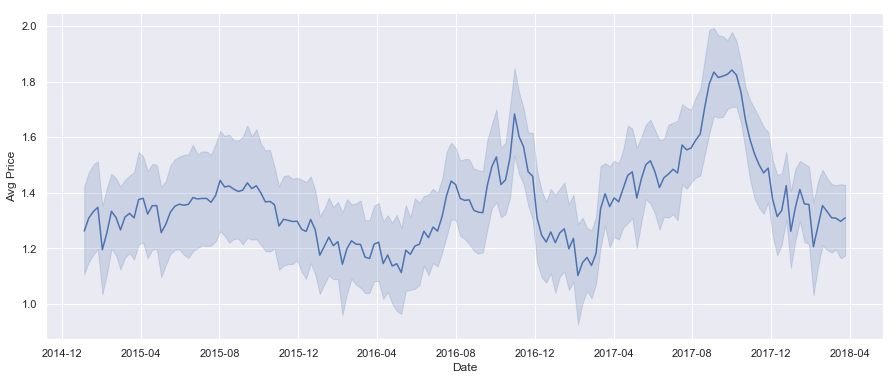

In [47]:
plt.figure(figsize=(15,6))
ax = sns.lineplot(x='Date', y='Avg Price', data=rgdata)
plt.show()

Now let's take a look at the total volume each region consumes. To assist, below is a graphic of the region breakdown. Keep in mind, California is not included in the 'West' region, but is a region of its own.

In [48]:
Image(url= "http://www.hassavocadoboard.com/sites/all/themes/hab/images/regions.jpg", width=550)

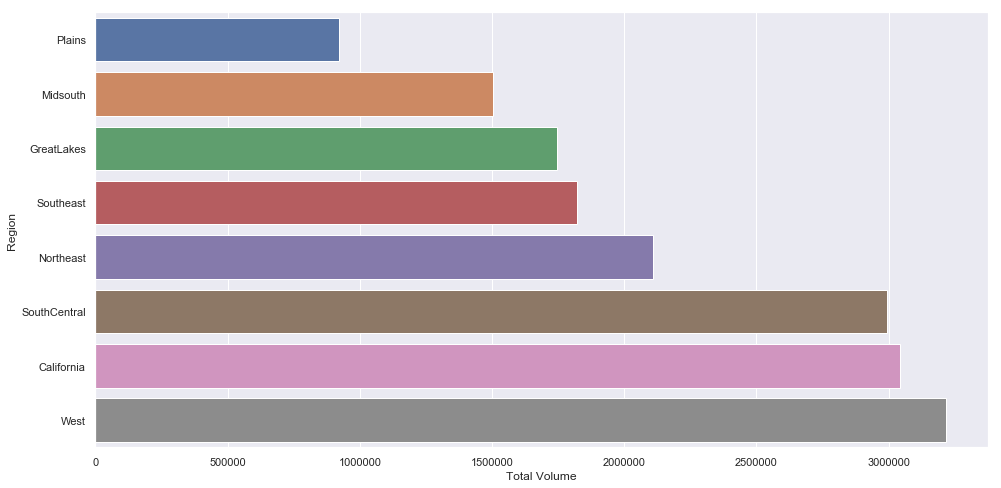

In [49]:
regionpct = rgdata.pivot_table(values='Total Volume', index='Region')
regionpct.sort_values('Total Volume', ascending=True, inplace=True)

plt.figure(figsize=(16,8))
sns.barplot(x='Total Volume',y=regionpct.index, data=regionpct)
plt.show()

## 5. New Features

__1. Month -__             Learn if there is any seasonality in the average price of avocados.<br>
__2. Quarter -__           What information can we learn if we combine months into quarters?<br>
__3. Individual Total -__  There is a column for Total Bags but all individual sales are seperate.<br>
__4. Region Dummies -__    Break up the Region column into individual features.<br>
__5. Neighbors Mexico -__  Split up the regions into ones that border Mexico and those that do not.<br>

In [50]:
# Add a column that reads the Date column and takes the month value
# Then convert to abbreviation
rgdata['Month'] = rgdata['Date'].dt.month

In [51]:
# Create a new column/dataset converting month values to their three letter abbreviations
months = rgdata[['Total Volume', 'Type', 'Month']]
months['Month'] = months['Month'].apply(lambda x: calendar.month_abbr[x])

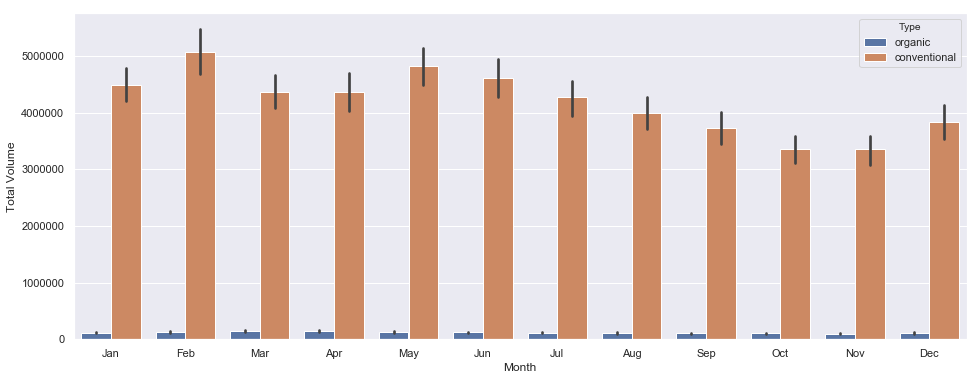

In [52]:
# Create a barplot of the Total Volume by month with a hue of Organic or Conventional
plt.figure(figsize=(16,6))
ax = sns.barplot(x='Month', y='Total Volume', hue='Type', data=months[::-1])
plt.show()

In [53]:
# Add a column summing all individual sales of Haas avocados
rgdata['Total Individual'] = rgdata['Haas-S'] + rgdata['Haas-L'] + rgdata['Haas-XL']

In [60]:
# Add a column converting Month into yearly Quarters
rgdata['Quarter'] = rgdata['Month'].replace([1,2,3,4,5,6,7,8,9,10,11,12],
                                            ['Q1','Q1','Q1','Q2','Q2','Q2',
                                             'Q3','Q3','Q3','Q4','Q4','Q4'])

In [71]:
# Add a column converting Region into two categories - neighbors Mexico = 1, not = 0
rgdata['NearMexico'] = rgdata['Region'].replace(['California', 'GreatLakes', 'Midsouth',
                                                 'Northeast', 'Plains','SouthCentral',
                                                 'Southeast', 'West'],
                                                [1,0,0,0,0,1,0,1])

In [72]:
rgdata.head()

,Date,Avg Price,Total Volume,Haas-S,Haas-L,Haas-XL,Total Bags,Small Bags,Large Bags,XLarge Bags,Type,Year,Region,Organic,Month,Total Individual,Quarter,NearMexico
312,2015-12-27,0.90,5040365.47,1833946.59,1760956.02,232755.85,1212707.01,1090140.07,110737.35,11829.59,conventional,2015,California,0,12,3827658.46,Q4,1
313,2015-12-20,0.94,4695737.21,1676601.43,1543280.76,266689.82,1209165.20,1061703.58,136747.10,10714.52,conventional,2015,California,0,12,3486572.01,Q4,1
314,2015-12-13,0.87,5259354.30,1806690.08,1627240.76,232985.13,1592438.33,1404012.00,180150.37,8275.96,conventional,2015,California,0,12,3666915.97,Q4,1
315,2015-12-06,0.78,5775536.27,1943065.50,2100246.17,221957.26,1510267.34,1376640.91,126664.37,6962.06,conventional,2015,California,0,12,4265268.93,Q4,1
316,2015-11-29,0.91,4575710.62,1461699.38,1810202.70,222311.07,1081497.47,991568.84,82338.39,7590.24,conventional,2015,California,0,11,3494213.15,Q4,1


In [67]:
# Create dummies for the Quarter and Region columns
quarter_dummies = pd.get_dummies(rgdata['Quarter'])
region_dummies = pd.get_dummies(rgdata['Region'])

In [74]:
# Combine the dummy columns to the dataframe and add a '1' value in their respective columns
rgdata2 = pd.concat([rgdata, quarter_dummies, region_dummies], 1)

In [75]:
rgdata2.head()

,Date,Avg Price,Total Volume,Haas-S,Haas-L,Haas-XL,Total Bags,Small Bags,Large Bags,XLarge Bags,...,Q3,Q4,California,GreatLakes,Midsouth,Northeast,Plains,SouthCentral,Southeast,West
312,2015-12-27,0.90,5040365.47,1833946.59,1760956.02,232755.85,1212707.01,1090140.07,110737.35,11829.59,...,0,1,1,0,0,0,0,0,0,0
313,2015-12-20,0.94,4695737.21,1676601.43,1543280.76,266689.82,1209165.20,1061703.58,136747.10,10714.52,...,0,1,1,0,0,0,0,0,0,0
314,2015-12-13,0.87,5259354.30,1806690.08,1627240.76,232985.13,1592438.33,1404012.00,180150.37,8275.96,...,0,1,1,0,0,0,0,0,0,0
315,2015-12-06,0.78,5775536.27,1943065.50,2100246.17,221957.26,1510267.34,1376640.91,126664.37,6962.06,...,0,1,1,0,0,0,0,0,0,0
316,2015-11-29,0.91,4575710.62,1461699.38,1810202.70,222311.07,1081497.47,991568.84,82338.39,7590.24,...,0,1,1,0,0,0,0,0,0,0


## 6. Filtering to Select Best Features

In [82]:
featuresdf = rgdata2[['Total Volume', 'Haas-S', 'Haas-L', 'Haas-XL', 'Total Bags',
                      'Small Bags', 'Large Bags', 'XLarge Bags', 'Organic', 'Month',
                      'Total Individual', 'NearMexico', 'Q1', 'Q2', 'Q3', 'Q4',
                      'California', 'GreatLakes', 'Midsouth', 'Northeast', 'Plains',
                      'SouthCentral', 'Southeast', 'West']]

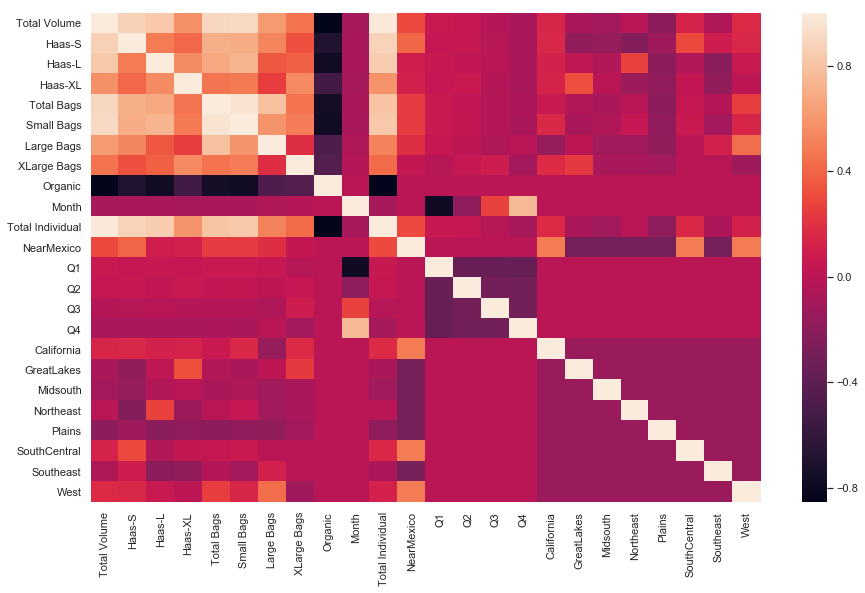

In [83]:
corrmat = featuresdf.corr()

plt.figure(figsize=(15,9))
sns.heatmap(corrmat)
plt.show()

In [84]:
means = featuresdf.mean(axis=0)
stds = featuresdf.std(axis=0)
rgdata2['All'] = ((featuresdf - means) / stds).mean(axis=1)

# Check how well the composite correlates with each of the individual variables.
plotdf = featuresdf
plotdf['All'] = rgdata2['All'] 
corrmat2 = plotdf.corr()

print(corrmat2)

                  Total Volume    Haas-S    Haas-L   Haas-XL  Total Bags  \
Total Volume          1.000000  0.866798  0.829247  0.576172    0.899865   
Haas-S                0.866798  1.000000  0.490043  0.407132    0.714232   
Haas-L                0.829247  0.490043  1.000000  0.553633    0.679382   
Haas-XL               0.576172  0.407132  0.553633  1.000000    0.460830   
Total Bags            0.899865  0.714232  0.679382  0.460830    1.000000   
Small Bags            0.905950  0.702515  0.737849  0.483463    0.960371   
Large Bags            0.619935  0.529733  0.350415  0.253328    0.791080   
XLarge Bags           0.450946  0.324308  0.378326  0.548715    0.456209   
Organic              -0.854840 -0.692924 -0.774573 -0.535418   -0.751119   
Month                -0.091796 -0.080712 -0.074320 -0.087738   -0.078047   
Total Individual      0.984081  0.879798  0.843276  0.590489    0.808025   
NearMexico            0.295826  0.401235  0.098025  0.114841    0.245944   
Q1          

In [81]:
rgdata2.columns

Index(['Date', 'Avg Price', 'Total Volume', 'Haas-S', 'Haas-L', 'Haas-XL',
       'Total Bags', 'Small Bags', 'Large Bags', 'XLarge Bags', 'Type', 'Year',
       'Region', 'Organic', 'Month', 'Total Individual', 'Quarter',
       'NearMexico', 'Q1', 'Q2', 'Q3', 'Q4', 'California', 'GreatLakes',
       'Midsouth', 'Northeast', 'Plains', 'SouthCentral', 'Southeast', 'West'],
      dtype='object')

## 7. Model Training

In [85]:
# Create X and y arrays separating the outcome variable from the feature variables
X = featuresdf
y = rgdata2['Avg Price']

In [86]:
# Split the data into test and train datasets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=101)

In [87]:
# Create a linear regression instance to call later
lm = LinearRegression()

In [88]:
lm.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

## 8. Model Evaluation 

In [89]:
# Check out the model's coefficients
coefficients = pd.DataFrame(lm.coef_,X.columns,columns=['Coefficient'])
coefficients

,Coefficient
Total Volume,-0.000005
Haas-S,0.000001
Haas-L,0.000001
Haas-XL,0.000001
Total Bags,0.026621
Small Bags,-0.026616
Large Bags,-0.026616
XLarge Bags,-0.026615
Organic,0.252884
Month,-0.016886


## 9. Predictions from the Model 

In [90]:
# See how well the test dataset can predict
predictions = lm.predict(X_test)

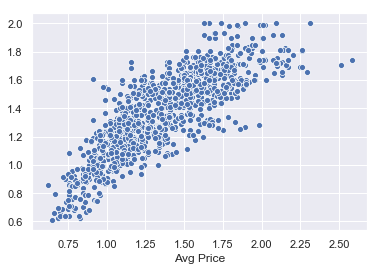

In [91]:
# Make a scatterplot of the data
sns.scatterplot(x=y_test, y=predictions)
plt.show()

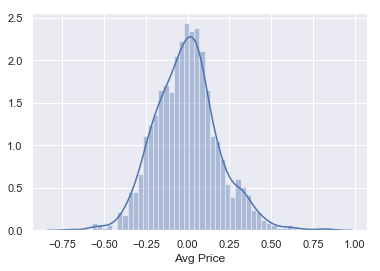

In [92]:
# Make a residual histogram of the data
sns.distplot((y_test-predictions), bins=50)
plt.show()

## 10. Evaluation Metrics

In [93]:
# Take a look at the evaluation metrics
print('Mean Absolute Error:     ', metrics.mean_absolute_error(y_test, predictions))
print('Mean Squared Error:      ', metrics.mean_squared_error(y_test, predictions))
print('Root Mean Squared Error: ', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

Mean Absolute Error:      0.14700482959959055
Mean Squared Error:       0.036452060396148324
Root Mean Squared Error:  0.190924226844443


## Resources

__1)__ https://www.cheatsheet.com/culture/why-avocados-are-so-expensive.html/<br>
__2)__ http://www.hassavocadoboard.com/